In [41]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/hs/1t60kyd15t31kkd07pldztrr0000gn/T/ipykernel_74214/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [42]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


## Project 1. Due by Thursday, February 13. ##

For this project we will use the **London Underground Data**.

1. Compute a Minimum Spanning Tree using, as costs, the straight-line distances of the provided connections, i.e., length of connections computed using the latitude and longitude of each node.

2. Repeat this computation, now using the length of connections provided in the data.

3. Using version 2 of the lengths, we will investigate the robustness of the computation.  We conduct 10000 experiments.  In each experiment the length of each connection is adjusted as follows:
        modified length = max{ (true length)*(1 + Gaussian(0,0.3)), 0.01*(true length) }
i.e., we modify the length randomly using a zero-norm Gaussian distribution with standard deviation 0.3 and correct if the length becomes too small.

  Plot the distribution of minimum spanning tree lengths, as well as the Value-At-Risk at level 5%.

4. Returning to the lengths as in version 2, conduct a delete-and-repair analysis.  That is to say, for each link L of the minimum spanning tree, we

    (a) Remove L from the network.
    
    (b) Compute a minimum spanning tree for the network with L (and only L) removed.  

  Plot the resulting values for the length of the minimum spanning tree.

Note: we only remove one link at a time.



### IMPORTANT ###
1. Please do not submit data.  If you need to generate additional data, submit the code for that as well.
2. By the due date for the project, please make an appointment with the TAs/CAs.  

### Loading Data
Each csv file was loaded into a Pandas dataframe

In [43]:
# Load data into Pandas Dataframes
connections = pd.read_csv("./London Underground/connections.csv", index_col=0)
lines = pd.read_csv("./London Underground/lines.csv")
stations = pd.read_csv("./London Underground/stations.csv")

In [44]:
# Cleaning Data - Drop any null rows
connections = connections.dropna()
lines = lines.dropna()
stations = stations.dropna()

In [45]:
connections

,station1,station2,line,time,distance(miles)
0,11,163,1,1.0,0.257855
1,11,212,1,2.0,0.454449
2,49,87,1,1.0,0.111148
3,49,197,1,2.0,0.426744
4,82,163,1,2.0,0.273407
...,...,...,...,...,...
401,198,272,11,1.0,0.412421
402,198,273,11,3.0,0.695057
403,224,260,11,3.0,0.783457
404,245,272,11,3.0,0.957943


In [46]:
stations

,Unnamed: 0,latitude,longitude,name,zone,total_lines,rail
0,1,51.5028,-0.2801,Acton Town,3.0,2.0,0.0
1,2,51.5143,-0.0755,Aldgate,1.0,2.0,0.0
2,3,51.5154,-0.0726,Aldgate East,1.0,2.0,0.0
3,4,51.5107,-0.0130,All Saints,2.0,1.0,0.0
4,5,51.5407,-0.2997,Alperton,4.0,1.0,0.0
...,...,...,...,...,...,...,...
297,299,51.4214,-0.2064,Wimbledon,3.0,1.0,1.0
298,300,51.4343,-0.1992,Wimbledon Park,3.0,1.0,0.0
299,301,51.6070,0.0341,Woodford,4.0,1.0,0.0
300,302,51.6179,-0.1856,Woodside Park,4.0,1.0,0.0


In [47]:
# Merge connections and stations into one dataframe

stations1 = stations.rename(columns={
    "Unnamed: 0": "station1",
    "latitude": "st1_latitude",
    "longitude": "st1_longitude",
    "name": "st1_station_name",
    "zone": "st1_zone",
    "total_lines": "st1_total_lines",
    "rail": "st1_rail"
})
stations2 = stations.rename(columns={
    "Unnamed: 0": "station2",
    "latitude": "st2_latitude",
    "longitude": "st2_longitude",
    "name": "st2_station_name",
    "zone": "st2_zone",
    "total_lines": "st2_total_lines",
    "rail": "st2_rail"
})

df = connections.merge(stations1, on="station1", how="left")
df = df.merge(stations2, on="station2",how="left")

df

,station1,station2,line,time,distance(miles),st1_latitude,st1_longitude,st1_station_name,st1_zone,st1_total_lines,st1_rail,st2_latitude,st2_longitude,st2_station_name,st2_zone,st2_total_lines,st2_rail
0,11,163,1,1.0,0.257855,51.5226,-0.1571,Baker Street,1.0,5.0,0.0,51.5225,-0.1631,Marylebone,1.0,1.0,1.0
1,11,212,1,2.0,0.454449,51.5226,-0.1571,Baker Street,1.0,5.0,0.0,51.5234,-0.1466,Regent's Park,1.0,1.0,0.0
2,49,87,1,1.0,0.111148,51.5080,-0.1247,Charing Cross,1.0,2.0,1.0,51.5074,-0.1223,Embankment,1.0,4.0,0.0
3,49,197,1,2.0,0.426744,51.5080,-0.1247,Charing Cross,1.0,2.0,1.0,51.5098,-0.1342,Picadilly Circus,1.0,2.0,0.0
4,82,163,1,2.0,0.273407,51.5199,-0.1679,Edgware Road (B),1.0,1.0,0.0,51.5225,-0.1631,Marylebone,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,198,272,11,1.0,0.412421,51.4893,-0.1334,Pimlico,1.0,1.0,0.0,51.4861,-0.1253,Vauxhall,1.5,1.0,1.0
402,198,273,11,3.0,0.695057,51.4893,-0.1334,Pimlico,1.0,1.0,0.0,51.4965,-0.1447,Victoria,1.0,3.0,1.0
403,224,260,11,3.0,0.783457,51.5822,-0.0749,Seven Sisters,3.0,1.0,1.0,51.5882,-0.0594,Tottenham Hale,3.0,1.0,1.0
404,245,272,11,3.0,0.957943,51.4723,-0.1230,Stockwell,2.0,2.0,0.0,51.4861,-0.1253,Vauxhall,1.5,1.0,1.0


### 1. Compute a Minimum Spanning Tree using, as costs, the straight-line distances of the provided connections, i.e., length of connections computed using the latitude and longitude of each node.

In [48]:
# A function to calculate the straight-line distances of the provided connections
def straightLineDistance(row):
    lat1, long1 = row["st1_latitude"], row["st1_longitude"]
    lat2, long2 = row["st2_latitude"], row["st2_longitude"]
    distance = np.sqrt((lat2-lat1)**2 + (long2-long1)**2)
 
    return distance

In [49]:
df["straight_line_distance"] = df.apply(straightLineDistance, axis=1)
df

,station1,station2,line,time,distance(miles),st1_latitude,st1_longitude,st1_station_name,st1_zone,st1_total_lines,st1_rail,st2_latitude,st2_longitude,st2_station_name,st2_zone,st2_total_lines,st2_rail,straight_line_distance
0,11,163,1,1.0,0.257855,51.5226,-0.1571,Baker Street,1.0,5.0,0.0,51.5225,-0.1631,Marylebone,1.0,1.0,1.0,0.006001
1,11,212,1,2.0,0.454449,51.5226,-0.1571,Baker Street,1.0,5.0,0.0,51.5234,-0.1466,Regent's Park,1.0,1.0,0.0,0.010530
2,49,87,1,1.0,0.111148,51.5080,-0.1247,Charing Cross,1.0,2.0,1.0,51.5074,-0.1223,Embankment,1.0,4.0,0.0,0.002474
3,49,197,1,2.0,0.426744,51.5080,-0.1247,Charing Cross,1.0,2.0,1.0,51.5098,-0.1342,Picadilly Circus,1.0,2.0,0.0,0.009669
4,82,163,1,2.0,0.273407,51.5199,-0.1679,Edgware Road (B),1.0,1.0,0.0,51.5225,-0.1631,Marylebone,1.0,1.0,1.0,0.005459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,198,272,11,1.0,0.412421,51.4893,-0.1334,Pimlico,1.0,1.0,0.0,51.4861,-0.1253,Vauxhall,1.5,1.0,1.0,0.008709
402,198,273,11,3.0,0.695057,51.4893,-0.1334,Pimlico,1.0,1.0,0.0,51.4965,-0.1447,Victoria,1.0,3.0,1.0,0.013399
403,224,260,11,3.0,0.783457,51.5822,-0.0749,Seven Sisters,3.0,1.0,1.0,51.5882,-0.0594,Tottenham Hale,3.0,1.0,1.0,0.016621
404,245,272,11,3.0,0.957943,51.4723,-0.1230,Stockwell,2.0,2.0,0.0,51.4861,-0.1253,Vauxhall,1.5,1.0,1.0,0.013990


In [50]:
G = nx.Graph()

# Add edges with distances as weights
for index, row in df.iterrows():
    G.add_edge(row['station1'], row['station2'], weight=row['straight_line_distance'])


In [51]:
mst = nx.minimum_spanning_tree(G, algorithm="prim")

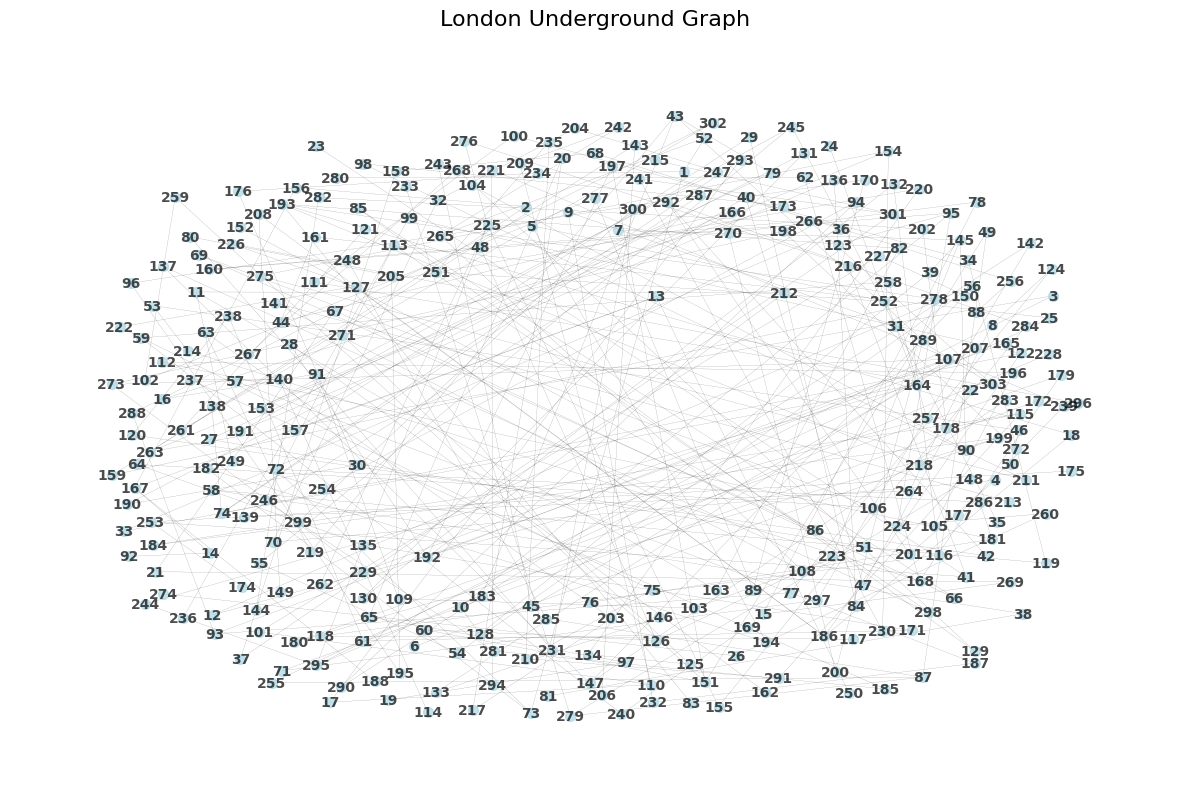

In [52]:
fig, ax = plt.subplots(figsize=(12, 8))

layout = nx.spring_layout(mst, k=1, iterations=10)

nx.draw(mst, 
        pos=layout,
        with_labels=True,
        node_color='lightblue',     # Light blue nodes
        node_size=50,               # Larger nodes
        font_size=10,               # Adjust font size
        font_weight='bold',         # Bold labels
        edge_color='black',          # Gray edges
        width=0.1,                  # Thicker edges
        alpha=0.7)                  # Some transparency

plt.title("London Underground Graph", fontsize=16, pad=20)

plt.tight_layout()

plt.show()

In [53]:
total_mst_cost = sum(nx.get_edge_attributes(mst, 'weight').values())
print(f"Total Minimum Spanning Cost using prim: {total_mst_cost:.2f}")

Total Minimum Spanning Cost using prim: 4.25


In [54]:
kruskal = nx.minimum_spanning_tree(G, algorithm="kruskal")
total_kruskal_cost = sum(nx.get_edge_attributes(kruskal, 'weight').values())
print(f"Total Minimum Spanning Cost using Kruskal: {total_kruskal_cost:.2f}")

Total Minimum Spanning Cost using Kruskal: 4.25


### 2. Repeat this computation, now using the length of connections provided in the data.

In [55]:
G2 = nx.Graph()

# Add edges with distances as weights
for index, row in df.iterrows():
    G2.add_edge(row['station1'], row['station2'], weight=row['distance(miles)'])


In [56]:
mst = nx.minimum_spanning_tree(G2, algorithm="prim")
total_mst_cost = sum(nx.get_edge_attributes(mst, 'weight').values())
print(f"Total Minimum Spanning Cost using prim: {total_mst_cost:.2f}")

Total Minimum Spanning Cost using prim: 217.38


In [57]:
mst = nx.minimum_spanning_tree(G2, algorithm="kruskal")
total_mst_cost = sum(nx.get_edge_attributes(mst, 'weight').values())
print(f"Total Minimum Spanning Cost using kruskal: {total_mst_cost:.2f}")

Total Minimum Spanning Cost using kruskal: 217.38
